In [1]:
# There are parts of this Notebook that will be executed (Or not) based on this flag
debug = False

## Imports
from unidecode import unidecode # To remove accents and stuff from texts
import re                       #Regular expression library
import geonamescache            # For database of places on earth
import numpy as np              # for array manipulation
import pandas                   # Final resut needs to be in this format
import json                     # For saving the results

In [2]:
export_json='../data/found_cities_locations.json'
with open(export_json, 'r') as checkJSONDump:
    jsonData=json.loads(checkJSONDump.read())
print("Example list of headlines with data:\n",jsonData[:3])

Example list of headlines with data:
 [{'line': 'Zika Outbreak Hits Miami', 'place': 'Miami', 'country': 'United States', 'places': ['Miami'], 'lat': 25.77427, 'lng': -80.19366, 'countrycode': 'US'}, {'line': 'Could Zika Reach New York City?', 'place': 'New York City', 'country': 'United States', 'places': ['York', 'New York City', 'New York'], 'lat': 40.71427, 'lng': -74.00597, 'countrycode': 'US'}, {'line': 'First Case of Zika in Miami Beach', 'place': 'Miami Beach', 'country': 'United States', 'places': ['Miami', 'Miami Beach'], 'lat': 25.79065, 'lng': -80.13005, 'countrycode': 'US'}]


### Calculating distances between 2 points in the Earth

So, I couldn't quite make work the function `great_circle_distance` for calculating the distance between 2 points (And I was already at a point in which the map was almost ready... and on the edge of nervous breakdown) so I googled a little and found an implementation in [Stack Overflow](https://stackoverflow.com/questions/365826/calculate-distance-between-2-gps-coordinates).

The example was in Javascript so I adapted it for Python, and it works we could say almost flawlessly.

I used the example in the page (London to Arlington, 5918 kilometers - 3666 miles acording to Google) and I fetched 2 cities from Australia that were close, Rockhampton and Gladstone, and the results are also similar to what Google gives (93 kilometers, 58 miles)

As the examples are using the imperial units I'll leave the code like that.

In [3]:
# Example cities from the list

# Rockhampton -23.38032 150.50595 AU 0
# Gladstone   -23.84852 151.25775 AU 0

# Refresher from Google
# Latitudes range from 0 to 90. Longitudes range from 0 to 180. Use N, S, E or W as either
# the first or last character, which represents a compass direction North, South, East or West.
# The last degree, minute, or second of a latitude or longitude may contain a decimal portion.

# I couldn't quite make work the distance fucntion given in the documentation, so I adapted one
# I found online

from math import cos, sin, asin, atan2, sqrt

debug = False
distance_count = 0

def geo_distance(P1, P2):
    # P1 and P2 are points in the map
    # The first value of each is going to be latitude, and the second longitude
    # Values must be in degrees: The function converst them to radians
    global distance_count
    earthRadius = 3958.8
    LA1, LO1 = P1
    LA2, LO2 = P2
    dLA = np.radians(LA2 - LA1)
    dLO = np.radians(LO2 - LO1)
    RA1 = np.radians(LA1)
    RA2 = np.radians(LA2)
    haversin = sin(dLA / 2) ** 2 + sin(dLO / 2) ** 2 * cos(RA1) * cos(RA2)
    dist = 2 * atan2( sqrt( haversin ), sqrt( 1 - haversin ) ) * earthRadius
    if debug:
        print(f"(geo_distance) >>> comparing point {P1} to point {P2} gives distance: {dist}")
    distance_count = distance_count + 1
    return dist

# This lines below are left for reference, as I've removed the great_circle_distance function
#r = great_circle_distance([51.5, 0], [38.8, -77.1])
#r = great_circle_distance([-23.38032, 150.50595], [-23.84852, 151.25775])

#r = geo_distance([51.5, 0], [38.8, -77.1])
#r = geo_distance([-23.38032, 150.50595], [-23.84852, 151.25775])

#print(np.radians(-23.38032 - -23.84852), np.radians(-23.38032) - np.radians(-23.84852))

### Listing 11.6 is wrong in the documentation

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
map_plotter = Basemap()

In [5]:
# Let's convert the data to a DataFrame
df = pandas.DataFrame(jsonData)

# We're using all columns 
df = df[df.columns[[0, 1, 4, 5, 6]]]

# Let's give them columns new names
df.columns = ['headline', 'city', 'latitude', 'longitude', 'countrycode']

# Drop the row index
blankIndex=[''] * len(df)
df.index=blankIndex

# Remove rows without location information
df = df[~np.isnan(df['longitude']) & ~np.isnan(df['latitude'])]
df[:15]

,headline,city,latitude,longitude,countrycode
,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US
,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO
,Zika Concerns are Spreading in Houston,Houston,29.76328,-95.36327,US
,Geneve Scientists Battle to Find Cure,Genève,46.20222,6.14569,CH
,The CDC in Atlanta is Growing Worried,Atlanta,33.74900,-84.38798,US
,Zika Infested Monkeys in Sao Paulo,São Paulo,-23.54750,-46.63611,BR


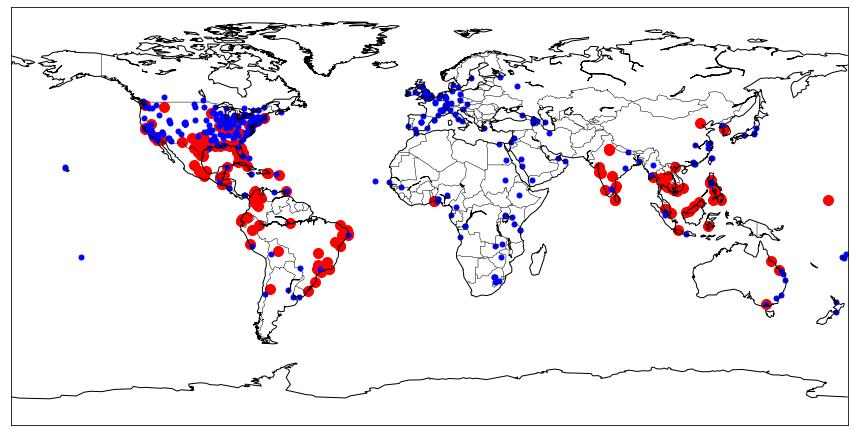

In [6]:
# A little fun with maps: Separate Zika related headlines from the rest

fig = plt.figure(figsize=(15, 8))
lats, longs = np.array(df[df['headline'].str.contains("Zika")][['latitude', 'longitude']]).T

map_plotter.drawcoastlines()
map_plotter.drawcountries()

map_plotter.scatter(longs, lats, latlon=True, s=100, c='r')

lats, longs = np.array(df[~df['headline'].str.contains("Zika")][['latitude', 'longitude']]).T
map_plotter.scatter(longs, lats, latlon=True, s=25, c='b')

plt.show()

### The explanation on figure 10.8 is good, but is missing how the points are chosen

In [7]:
from sklearn.cluster import DBSCAN

#### Pizzas, continents and cities

In order to achieve a somewhat meaningful result (Or something that resenbled the picture shown in the "submit your work" page for this assignment) I had to sub group the data and use different parameters mfor the clustering, as can be observed in the `data` variable below.

The colors were fetched from a few palettes in [this page](https://carto.com/carto-colors/)

The map is not shaded, thought, as it would kill the notebood due to a meory problem.

BTW, I think the culustering shown in the page stated about is totally arbitrary, and from my point of view the most important part of the "data science" part of this assignment would be preciselly that, discussing how to reach a criteria for sub clustering the data, and not drawing pretty colored points in a map.

Same as the linked reference, I'd rather know how the "elboW" procedure works than just knowing that it exists.

I think the explanation about it leaves a ver important point (How to choose the points to use?) out.

Also, I'd want to stress out that I wasted an anormous amount of time in this because the function  provided for calculating distances between geo points was utterly wrong.

In the cell below, the **most important line in it** is probably this one:

`df.loc[filterdf, 'cluster'] = (disease_clusters > 0) * (disease_clusters + df.cluster.max())`
As it is the line of code that stores the data fetched by the clustering in a way that it is stored correctly, and that it is not overwritten nor mixed up.

Check the comment son the cell for an explanation of how it works.

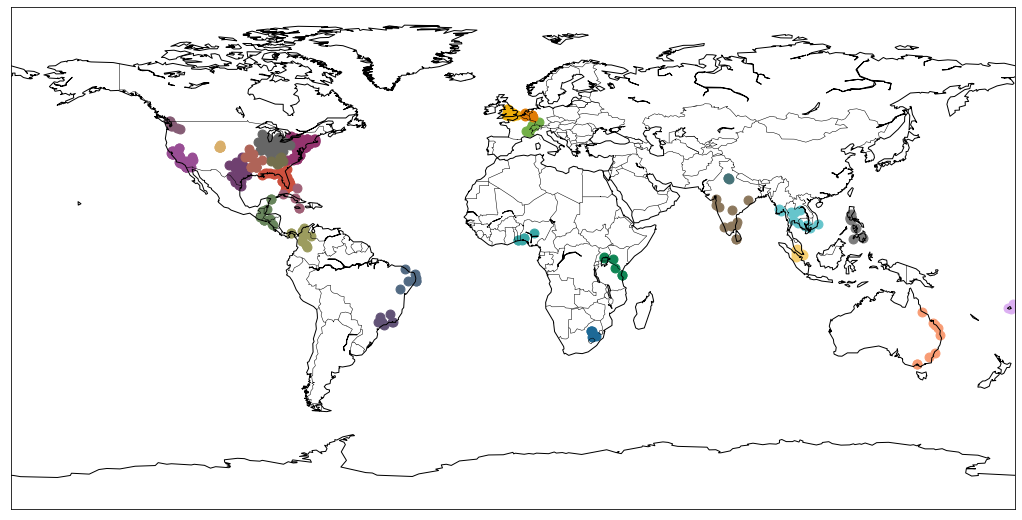

In [8]:
fig = plt.figure(figsize=(18, 12))

# Let's add the cluster column
df['cluster'] = 0

distance_count = 0

data = {
    'south_america': {'eps': 300, 'spots': 5, 'lat': -8.7832, 'lng': -55.4915},
    'north_america': {'eps': 150, 'spots': 6, 'lat': 40.5260, 'lng': -105.2551},
    'europe': {'eps': 120, 'spots': 4, 'lat': 44.5260, 'lng': 15.2551},
    'africa': {'eps': 400, 'spots': 5, 'lat': -8.7832, 'lng': 24.5085},
    'india': {'eps': 500, 'spots': 5, 'lat': 20.5937, 'lng': 78.9629},
    'south_asia': {'eps': 300, 'spots': 5, 'lat': 12.7359, 'lng': 110.0188},
    'australia': {'eps': 480, 'spots': 5, 'lat': -25.2744, 'lng': 133.7751},
    'pacific_ocean': {'eps': 300, 'spots': 3, 'lat': -25.2744, 'lng': 143.7751},
    # '': {'eps': , 'spots': , 'lat': , 'lng': },
}

colors = "" # A little OCD
colors = colors + "#5F4690,#1D6996,#38A6A5,#0F8554,#73AF48,#EDAD08,#E17C05,#CC503E,#94346E,"
colors = colors + "#6F4070,#994E95,#666666,#855C75,#D9AF6B,#AF6458,#736F4C,#526A83,#625377,"
colors = colors + "#68855C,#9C9C5E,#A06177,#8C785D,#467378,#7C7C7C,#66C5CC,#F6CF71,#F89C74,"
colors = colors + "#DCB0F2,#87C55F,#9EB9F3,#FE88B1,#C9DB74,#8BE0A4,#B497E7,#D3B484,#B3B3B3,"
colors = colors.split(',')
color_pos = 0

areas = ['africa', 'europe', 'north_america', 'south_america', 'india', 'south_asia', 'australia', 'pacific_ocean']

# The code below could be added to the data variable above, but would make things even more
# unreadable

for filter in areas:
    # south_asia
    if filter == 'south_asia':
        # epsilon = 700 # <<< This epsilon produces a result simlar to the one shown as example
        # But it is too big if you ask me
        # 3 clusters
        filterdf = ((df['longitude'] > df[df['countrycode'] == 'IN']['longitude'].max())
            & (df['countrycode'] != 'AU') &
            (df['longitude'] < df[df['countrycode'] == 'AU']['longitude'].max()))

    # australia
    if filter == 'australia':
        # 1 cluster
        filterdf = (df['countrycode'] == 'AU')

    # pacific_ocean
    if filter == 'pacific_ocean':
        # 1 cluster
        filterdf = (df['longitude'] > df[df['countrycode'] == 'AU']['longitude'].max())

    # india
    if filter == 'india':
        #2 clusters
        filterdf = ((df['countrycode'] == 'IN') | ((df['longitude'] > 72)
                                                      & (df['longitude'] < 85.5)))
    # south_america
    if filter == 'south_america':
        # 10 clusters
        filterdf = ((df['longitude'] < -30) & ~df['countrycode'].isin(['US', 'CA', 'MX'])
                  | ((df['countrycode'] =='MX') & (df['latitude'] < 26)))

    #north america
    if filter == 'north_america':
        #10 clusters
        filterdf = ((df['longitude'] < -30) & df['countrycode'].isin(['US', 'CA'])
                  | ((df['countrycode'] =='MX') & (df['latitude'] > 26)))

    if filter == 'europe': # latitude > 37 longitude > -10
        # 3 clusters
        filterdf = (df['latitude'] > 35.7) & (df['longitude'] > -10) & (df['longitude'] < 100)

    if filter == 'africa':
        #3 clusters
        filterdf = (df['latitude'] < 35.7) & (df['longitude'] > -30) & (df['longitude'] < 70)

    subdf = df[filterdf].copy()
    
    # we extract the locations for the sub clustering
    incidents = np.array(subdf[['latitude', 'longitude']])

    # variables used for clustering and for the maps. The map related vars are not actually used
    epsilon, min_spots, map_lat, map_lng = list(data[filter].values())

    # Clustering
    clusters = DBSCAN(eps = epsilon, min_samples = min_spots,
                      metric = geo_distance)
    disease_clusters = clusters.fit_predict(incidents) + 1 # Let's convert this to zero based

    # Move fast and break things

    # This is probably the most important line in this cell:
    # Setting the value of the cluster field in the data frame
    # It has to be done in a such a way that zeros are unaccounted for (As those are cities
    #     without cluster)
    # and so that the numbers do not overlap, so as to not mix clusters.
    # `(disease_clusters > 0)` returns an array of true and false values, true for all clustered cities
    # (disease_clusters + df.cluster.max()) ads the maximum value currently in the cluster column
    # to the current cluster value, so as to displace the values in the array to the maximum found
    # currently in the cluster column (So, if the maximum value is currently 6, it will start at 7)
    # the multiplcation of the 2 groups resets the values that are zero in the array
    df.loc[filterdf, 'cluster'] = (disease_clusters > 0) * (disease_clusters + df.cluster.max())

ortho_plotter = Basemap()
for cluster_id, df_cluster in df.groupby('cluster'):
        if cluster_id < 1:
            continue
        latitudes, longitudes = np.array(df_cluster[['latitude', 'longitude']]).T
        ortho_plotter.scatter(longitudes, latitudes, latlon=True, c=colors[cluster_id], s=80)

ortho_plotter.drawcoastlines()
ortho_plotter.drawcountries()
#ortho_plotter.shadedrelief() <<<---- This gives a memory error, not going to wrestle it
plt.show()

### Also, the map legend: Not even going there. Spent too much time fighting this already
